Wylie Mickelson, Griffin Guyer

Final Project :  **Real VS Fake Job Classifier**

This colab file is the holds the Logistic Regression model used in our paper.

#Reading Data

This section simply imports packages needed for reading the CSV and Cleaning the data. It also executes the commands to read the csv file into a pandas dataframe. The file itself has to be upload to the colab notebook with the same name as the filename variable

In [ ]:
import numpy as np
import pandas as pd

import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
filename = 'fake_job_postings.csv'
#This is where the data is read from the file based on the filename given.
df = pd.read_csv(filename)
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


# Data Cleaning

Here is where the data is cleaned. We use the nltk, regular expressions, and string packages to do this operation.
We firstly select only the text based columns.
From there, each row is combined into one string and we use regular expression substition to remove common non word strings.
Once that is done, nltk tokenizes each row and removes their list of stopwords.

In [ ]:
# Choose text features and remove null values
text_cols = ["title", "location", "company_profile", "description", "requirements", "benefits"]

text_df = df[text_cols]
text_df = text_df.fillna(' ')

In [ ]:
# Combine text data for modeling
text = text_df[text_df.columns[0:-1]].apply(lambda x: ' '.join(x),axis=1)
target = df['fraudulent']

# Clean text of common non-word strings
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

text = text.apply(lambda x: clean_text(x))

In [ ]:
# Tokenize text using nltk
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

text = text.apply(lambda x: tokenizer.tokenize(x))

In [ ]:
# Remove common english stopwords
stop_words = stopwords.words('english')
def remove_stopwords(text):
    words = [w for w in text if w not in stop_words]
    return words

text = text.apply(lambda x : remove_stopwords(x))
text = text.apply(lambda x: ' '.join(x))

#Split dataset
This simply splits the dataset into two partitions: Trainging and testing. This is done using the sklearn packages. Once it is split using those functions, we count to make sure that there is a enough fake examples in each partition

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import random

In [ ]:
#Split dataset
train_text, test_text, train_target, test_target = train_test_split(text, target, test_size=0.2, random_state=42)

#Count distribution in train set
fake_train = 0
real_train = 0
for bin in train_target:
  if(bin):
    fake_train += 1
  else:
    real_train += 1
print(f"Amount of fakes in train: {fake_train}")
print(f"Amount of reals in train: {real_train}")

#Count distribution in test set
fake_test = 0
real_test = 0
for bin in test_target:
  if(bin):
    fake_test += 1
  else:
    real_test += 1
print(f"Amount of fakes in test: {fake_test}")
print(f"Amount of reals in test: {real_test}")


Amount of fakes in train: 685
Amount of reals in train: 13619
Amount of fakes in test: 181
Amount of reals in test: 3395


#TFIDF Vectorization

Once the datasets are split, we calculate the tf-idf scores. This is done by using the sklearn functions.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score

#Calculate tf-idf scores
tfidf = TfidfVectorizer(min_df=0.0,max_df=1.0,use_idf=True,ngram_range=(1,3))
tfidf_train_text = tfidf.fit_transform(train_text)
tfidf_test_text = tfidf.transform(test_text)

#Display shape of each sets tf-idf scores
print('Tfidf_train:', tfidf_train_text.shape)
print('Tfidf_test:', tfidf_test_text.shape)

Tfidf_train: (14304, 2395402)
Tfidf_test: (3576, 2395402)


#Logistic Regression

Once all of that has been done we are able to execute the Logistic Regression model. This again happens through the sklearn packages. We input our tf-idf scores and the labels for each row. Once the model is trained with that process, it is tested in a very similar way and the results are displayed.

In [ ]:
#Train model on train set tf-idf scores
log_reg = LogisticRegression()
log_reg.fit(tfidf_train_text, train_target)

LogisticRegression()


TFIDF Confusion Matrix



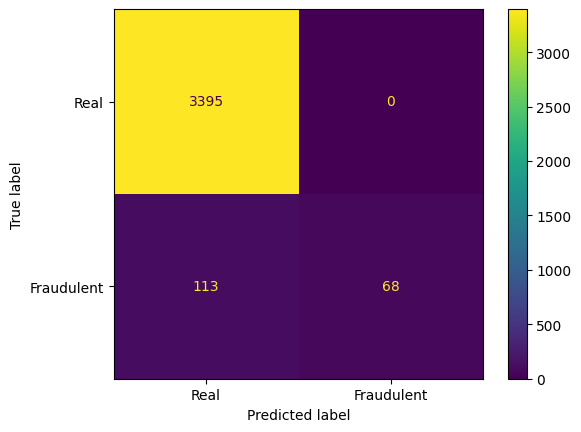


TFIDF Prediction Report

              precision    recall  f1-score   support

        Real       0.97      1.00      0.98      3395
  Fraudulent       1.00      0.38      0.55       181

    accuracy                           0.97      3576
   macro avg       0.98      0.69      0.76      3576
weighted avg       0.97      0.97      0.96      3576



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Test model on test set tf-idf scores
predictions = log_reg.predict(tfidf_test_text)
tfidf_confusion_matrix = confusion_matrix(test_target, predictions)

#Display results of the test's confusion matrix
tfidf_confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=tfidf_confusion_matrix, display_labels=["Real", "Fraudulent"])
tfidf_confusion_matrix_display.plot()
print("\nTFIDF Confusion Matrix\n")
plt.show()

#Display results of test's classification report
tfidf_report = classification_report(test_target, predictions, target_names = ['Real','Fraudulent'])
print("\nTFIDF Prediction Report\n")
print(tfidf_report)

This is the Logistic Regression model. The BERT model is in the python file.